In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import datetime
import psycopg2
from sqlalchemy import create_engine
import sqlalchemy
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
projects = ['p50_david_dietz_2020','p50_hao_chen_2020','p50_hao_chen_2020_rnaseq','p50_paul_meyer_2020',
            'u01_olivier_george_cocaine', 'u01_olivier_george_oxycodone', 'u01_olivier_george_scrub',
            'u01_peter_kalivas_italy', 'u01_peter_kalivas_us', 'u01_suzanne_mitchell', 'u01_tom_jhou' ]
def runQuery(query):
    connection = psycopg2.connect(database = "PalmerLab_Datasets",
                                  user = "postgres",
                                  password = "palmerlab-amapostgres",
                                  host = "palmerlab-main-database-c2021-08-02.c6sgfwysomht.us-west-2.rds.amazonaws.com",
                                  port = '5432')
    cursor = connection.cursor()
    if "SELECT" in query:
        table = pd.read_sql(query, con = connection)
    elif "UPDATE" in query:
        cursor.execute(query)
        print(query)
        connection.commit()
    elif "DELETE" in query:
        cursor.execute(query)
        print(query)
        connection.commit()
    else:
        return None
    if connection:
        cursor.close()
        connection.close()
        if "SELECT" in query:
            return table
        else:
            return
#change project here
current_project = projects[0]
data = runQuery("SELECT * FROM " + current_project + ".wfu_master")
data = data.replace('nan', np.nan)


In [44]:
def column_qc():
    print("Column headers for: "+ current_project)
    for column in data.columns:
        print(column)
    common_headers = ['cohort','sires','dames','labanimalid','accessid','sex','rfid','dob','dow','shipmentdate',
                      'litternumber','littersize','coatcolor','earpunch','rack','shipmentbox','shipmentage','weanage',
                      'comments','resolution']
    #find any odd column headers
    for column in data.columns:
        if column not in common_headers:
            print("\nNon uniform column headers:")
            print(column)
column_qc()

Column headers for: p50_david_dietz_2020
cohort
sires
dames
labanimalid
accessid
sex
rfid
dob
dow
shipmentdate
litternumber
littersize
coatcolor
earpunch
rack
shipmentbox
shipmentage
weanage
comments
resolution


In [45]:
data.head()

,cohort,sires,dames,labanimalid,accessid,sex,rfid,dob,dow,shipmentdate,litternumber,littersize,coatcolor,earpunch,rack,shipmentbox,shipmentage,weanage,comments,resolution
0,C02,74784_1,74728_1,J126,75445_6,F,CC1DCD17D2,2020-01-12,2020-02-03,2020-02-10,3.0,14.0,BROWN,RB,A-F5,10.0,29.0,22.0,None,None
1,C01,74115_1,74123_2,J002,74974_5,M,CC1DCD1750,2019-10-12,2019-11-04,2019-11-18,5.0,11.0,ALBINO,RT,C-F1,1.0,37.0,23.0,None,None
2,C01,74123_1,74197_2,J005,74977_5,M,CC1DCD1769,2019-10-12,2019-11-04,2019-11-18,4.0,11.0,BROWN,LM,C-F2,1.0,37.0,23.0,None,None
3,C01,74236_1,74127_2,J006,74976_5,M,CC1DCD17A6,2019-10-12,2019-11-04,2019-11-18,4.0,11.0,BLACK,RT,C-F2,1.0,37.0,23.0,None,None
4,C01,73784_1,73676_2,J009,74975_5,M,CC1DCD1775,2019-10-13,2019-11-04,2019-11-18,8.0,10.0,ALBINO,RB,C-F3,1.0,36.0,22.0,TRANSPONDER IN BACK,None


Cohorts for p50_david_dietz_2020 and the number of subjects in each:


C01     58
C02    112
C03    112
C04    112
C05    112
C06    112
C07    112
C08    112
C09    112
Name: cohort, dtype: int64

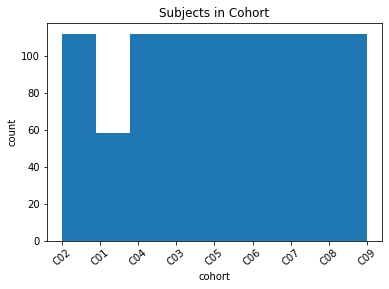

In [46]:
def cohorts():
    print("Cohorts for " + current_project + " and the number of subjects in each:")
    display(data['cohort'].value_counts().sort_index())
    bins = len(data['cohort'].unique())

    plt.title('Subjects in Cohort')
    plt.xlabel('cohort')
    plt.ylabel('count')
    plt.xticks(rotation = 40)
    plt.hist(data['cohort'].dropna(), bins = bins)    
    plt.show() 
cohorts()

In [47]:
def qc_pedigree(data):
    sires = list(data["sires"])
    dames = list(data["dames"])
    
    data = data.sort_values(["cohort", "labanimalid"])

    # Printing number of mothers and fathers per cohort
    unique_sires = []
    unique_dames = []
    for cohort in np.unique(data["cohort"]):
        subset = data[data["cohort"] == cohort]
        sires = list(subset["sires"])
        dames = list(subset["dames"])
        unique_sires.append(len(set(sires)))
        unique_dames.append(len(set(dames)))
        print(cohort, "sires", "total", len(sires), "unique", len(set(sires)))
        print(cohort, "dames", "total", len(dames), "unique", len(set(dames)))
#     plot_list = {'Sires':unique_sires,'Dames':unique_dames}
#     bins = len(data['cohort'].unique())
#     for name,value in plot_list.items():
#         plt.title(name)
#         plt.xlabel('unique subjects')
#         plt.ylabel('count')
#         plt.xticks(rotation = 40)
#         plt.hist(value, bins = bins)    
#         plt.show()
    # Printing animals listed as mother and father

    #print("sires", len(set(sires)), "dames", len(set(dames)), "overlap", len(overlap))

    # Checking sibling numbers
    parents_dict = {}
    parents_litter_birth = {}
    dob = []
    litter = []
    parents_df = pd.DataFrame()
    for index, row in data.iterrows():
        parents = (row["sires"], row["dames"])
        
        if parents in parents_dict.keys():
            parents_dict[parents].append(row["rfid"])
            parents_litter_birth[parents].append(row["dob"])
        else:
            dob.append(row['dob'])
            litter.append(row['littersize'])
            parents_dict[parents] = [row["rfid"]]
            parents_litter_birth[parents] = [row["dob"]]
            parents_df = parents_df.append({'sires':row["sires"],'dames':row["dames"]},ignore_index = True)
    print("\nparent pairs",len(parents_dict.keys()), '\n')
    siblings = []
    for parents in parents_dict.keys():
        #print(parents, len(parents_dict[parents]))#, parents_dict[parents])
        siblings.append(len(parents_dict[parents]))
        cohorts = []
        for rfid in parents_dict[parents]:
            subset = data[data["rfid"] == rfid]
            subset.index = range(subset.shape[0])
            i_cohort = list(subset.columns).index("cohort")
            cohorts.append(subset.iloc[0, i_cohort])
        cohorts = list(np.unique(cohorts))
        if len(cohorts) != 1:
            print("parent pair across multiple cohorts found", cohorts)
    parents_df['siblings'] = siblings
    parents_df['dob'] = dob
    parents_df['litter_size'] = litter
    parents_df['removed_litter'] = parents_df['litter_size'] - parents_df['siblings']
    

        
    #Check if there are any matching ids between sires and dames
    overlap = set(dames).intersection(set(sires))
    if len(list(overlap)) > 0:
        print("\nError: listed as dame and sire", list(overlap))
    elif len(list(overlap)) == 0:
        print('\nNo rfids labeled as both a sire and a dame')
    mislabeled_df = pd.DataFrame()
    unique_sires = data.sires.unique()
    unique_dames = data.dames.unique()
    mislabeled = [x for x in unique_sires if x in unique_dames]
    if len(overlap) > 0:
        mislabeled_nan_sires = data[data['sires'].isnull()]
        mislabeled_nan_dames = data[data['dames'].isnull()]
        mislabeled_nan = pd.concat([mislabeled_nan_sires,mislabeled_nan_dames]).drop_duplicates().reset_index(drop=True)
        if len(mislabeled_nan.index) > 0:
            print('\nMissing Sires/Dames for ' + current_project)
            display(mislabeled_nan)
        for rfid in mislabeled:
            mislabeled_df.append(data.loc[data['sires'] == rfid])
            mislabeled_df.append(data.loc[data['dames'] == rfid])
        if len(mislabeled_df.dropna().index) > 0:
            print('Mislabeled Sires/Dames')
            display(mislabeled_df.dropna())
        
    
    
    #print(parents_df)
    #print(parents_df.litter_size.unique())
    #print(data.littersize.unique())
    #print(parents_df.removed_litter.unique())
    df_litter_error = parents_df[(parents_df['removed_litter'] <= 0)]
    #print(parents_litter_birth)
    return
qc_pedigree(data)

C01 sires total 58 unique 29
C01 dames total 58 unique 29
C02 sires total 112 unique 56
C02 dames total 112 unique 56
C03 sires total 112 unique 55
C03 dames total 112 unique 55
C04 sires total 112 unique 54
C04 dames total 112 unique 54
C05 sires total 112 unique 57
C05 dames total 112 unique 57
C06 sires total 112 unique 56
C06 dames total 112 unique 56
C07 sires total 112 unique 56
C07 dames total 112 unique 56
C08 sires total 112 unique 57
C08 dames total 112 unique 57
C09 sires total 112 unique 59
C09 dames total 112 unique 59

parent pairs 440 

parent pair across multiple cohorts found ['C03', 'C04']
parent pair across multiple cohorts found ['C03', 'C05']
parent pair across multiple cohorts found ['C03', 'C05']
parent pair across multiple cohorts found ['C03', 'C05']
parent pair across multiple cohorts found ['C03', 'C04']
parent pair across multiple cohorts found ['C03', 'C05']
parent pair across multiple cohorts found ['C03', 'C05']
parent pair across multiple cohorts found [

2020-01-17 2020-01-04
2019-10-19 2019-10-12
2020-10-17 2020-10-04
2020-08-08 2020-07-25
2021-12-31 2020-12-19
2021-04-08 2021-03-27
2021-08-06 2021-07-24
2021-10-23 2021-10-09
2022-02-10 2022-01-30


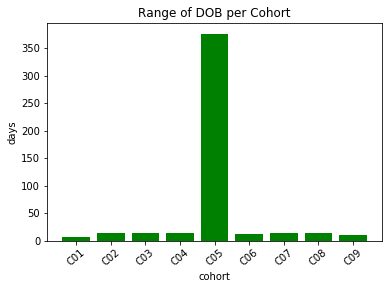

In [48]:
#Split data based on cohorts
#each cohort has their own df named after their cohort. Ex. C07
def birth_range():
    cohorts = data.cohort.unique()
    for i in cohorts:
        a = data[data.cohort == i]
        globals()[f"{i}"] = a

    #Check that the dob for each cohort is within a certain range
    #right now just outputs the cohort with the day span
    cohorts = data.cohort.unique()
    dob_range = {}
    for i in cohorts:
        globals()[f"dates_{i}"] = globals()[f"{i}"].dob.unique()
        oldest = min(globals()[f"dates_{i}"])
        youngest = max(globals()[f"dates_{i}"])
        difference = youngest - oldest
        dob_range[i] = difference
        print(youngest,oldest)


    dates = list(dob_range.values())
    keys = list(dob_range.keys())
    values = []
    dates_1 = []
    for date in dates:
        values.append(date.days)
    res = dict(zip(keys, values))
    dob_range
    sorted_dict = {k: res[k] for k in sorted(res)}
    plt.bar(sorted_dict.keys(), sorted_dict.values(), color='g')
    plt.title('Range of DOB per Cohort')
    plt.xlabel('cohort')
    plt.ylabel('days')
    plt.xticks(rotation = 40)   
    plt.show() 
birth_range()
#dates

In [49]:
# Fixing coatcolor in sample_metadata
def coat_color(data):
    toFix = []
    metadata = data
    print("Before Coat Color Normalization:")
    display(data['coatcolor'].value_counts())

    # metadata = select_wfu_master("u01_olivier_george_oxycodone")
    i_coatcolor = list(metadata.columns).index("coatcolor")
    for index, row in metadata.iterrows():
        coatcolor = data.iloc[index, i_coatcolor]
        if coatcolor == "BLK HOOD":
            coatcolor = "BLACKHOOD"
        elif coatcolor == "BRN HOOD":
            coatcolor = "BROWNHOOD"
        elif coatcolor == "BEN HOOD":
            coatcolor = "BROWNHOOD"
        elif coatcolor == "ALIBINO":
            coatcolor = "ALBINO"
        coatcolor = coatcolor.replace(" ", "")
        if coatcolor != metadata.iloc[index, i_coatcolor]:
            toFix.append(index)
            metadata.iloc[index, i_coatcolor] = coatcolor
    metadata = metadata.iloc[toFix, :]
    metadata.index = range(metadata.shape[0])
    print("After Coat Color Normalization:")
    display(data['coatcolor'].value_counts())

#     if len(metadata.index) > 0:
#         print("Need to normalize following rows for coat color:")
#         display(metadata)
coat_color(data)

Before Coat Color Normalization:


BLACK         209
BLACKHOOD     192
BROWN         184
BROWNHOOD     183
ALBINO        142
BRN HOOD       23
BLK HOOD       17
BLACK HOOD      3
BLACK           1
Name: coatcolor, dtype: int64

After Coat Color Normalization:


BLACKHOOD    212
BLACK        210
BROWNHOOD    206
BROWN        184
ALBINO       142
Name: coatcolor, dtype: int64

In [50]:
def qc_rfid(rfid, prefix, length):
    # Checking if prefix is present
    if rfid[:len(prefix)] != prefix:
        return False
    # Checking is rfid is correct length
    elif len(rfid) != length:
        return False
    return True

In [51]:
#Check to make sure rfid for the project contains the correct naming convention
project_metadata = pd.read_csv("project_metadata - project_metadata.csv", dtype = str)
i_convention = list(project_metadata.columns).index("rfid_convention")
for project in projects:
    print(project)
    data = runQuery("SELECT * FROM " + project + ".wfu_master")
    subset = project_metadata[project_metadata["project_name"] == project]
    subset.index = range(subset.shape[0])
    convention_list = subset.iloc[0, i_convention]
    if isinstance(convention_list, float):
        continue
    convention_list = convention_list.split(";")
    for i in range(len(convention_list)):
        convention_list[i] = convention_list[i].replace("(", "").replace(")", "").split(",")
    for rfid in data["rfid"]:#data needs to be combination of all projec
        passed = False
        for convention in convention_list:
            prefix = convention[0]
            length = int(convention[1])
            passed = passed + qc_rfid(rfid, prefix, length)
        if not passed:
            print(rfid, project)

p50_david_dietz_2020
E11DCD33DD p50_david_dietz_2020
p50_hao_chen_2020
p50_hao_chen_2020_rnaseq
76808_1 p50_hao_chen_2020_rnaseq
76750_9 p50_hao_chen_2020_rnaseq
77493_3 p50_hao_chen_2020_rnaseq
p50_paul_meyer_2020
AA1DCD664 p50_paul_meyer_2020
u01_olivier_george_cocaine
u01_olivier_george_oxycodone
u01_olivier_george_scrub
u01_peter_kalivas_italy
u01_peter_kalivas_us
u01_suzanne_mitchell
u01_tom_jhou


In [32]:
subset

,project_name,PI_name,project_title,project_description,phenotypic_data,comments,gbs,lcwgs_riptide,hcwgs_kapahyper,rnaseq,...,pacbio_smrt,ont,microbiome,metabolome,rfid_convention,rfid_example,derived_project,animal_source,species,notes


In [42]:
project_metadata

,project_name,PI_name,project_title,project_description,phenotypic_data,comments,gbs,lcwgs_riptide,hcwgs_kapahyper,rnaseq,...,pacbio_smrt,ont,microbiome,metabolome,rfid_convention,rfid_example,derived_project,animal_source,species,notes
0,p50_david_dietz_2020,David Dietz,NaN,NaN,TRUE,NaN,FALSE,TRUE,FALSE,FALSE,...,FALSE,FALSE,FALSE,FALSE,"(CC1DCD,10)",CC1DCD17D2,FALSE,NaN,NaN,NaN
1,p50_hao_chen_2014,Hao Chen,SOCIALLY-ACQUIRED NICOTINE SELF-ADMINISTRATION,NaN,TRUE,NaN,TRUE,TRUE,FALSE,TRUE,...,FALSE,FALSE,TRUE,FALSE,"(000,10)",00077E8D19,FALSE,hs rats,NaN,NaN
2,p50_hao_chen_2014_rnaseq,Hao Chen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"(000,10)",NaN,TRUE,p50_hao_chen_2014,NaN,NaN
3,p50_hao_chen_2020,Hao Chen,SOCIALLY-ACQUIRED NICOTINE SELF-ADMINISTRATION,NaN,TRUE,NaN,FALSE,TRUE,FALSE,FALSE,...,FALSE,FALSE,FALSE,FALSE,"(BB1DCD,10);(DD1DCD,10);(003B9,10);(E21DCD,10)","BB1DCD6EF6,DD1DCD2127,003B9ACFA6",FALSE,hs rats,NaN,NaN
4,p50_hao_chen_2020_rnaseq,Hao Chen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"(933000,15);(1DCD,8);(E21DCD,10);(AA1DCD,10)","933000320048512,1DCD37B9,E21DCD3649,AA1DCD67CE...",FALSE,NaN,NaN,rfid_convention: access ids (76750_9) used for...
5,p50_jerry_richards_2014,Jerry Richards,Association between behavioral regulation and ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"(000,10)",00077E7C3B,FALSE,NaN,NaN,NaN
6,p50_paul_meyer_2014,Paul Meyer,Association between behavioral regulation and ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"(000,10)",00071F4FAF,FALSE,NaN,NaN,NaN
7,p50_paul_meyer_2020,Paul Meyer,NEUROGENETIC SUBSTRATES OF COCAINE ADDICTION,NaN,TRUE,NaN,FALSE,TRUE,FALSE,FALSE,...,FALSE,FALSE,FALSE,FALSE,"(AA1DCD,10)",AA1DCD652A,FALSE,hs rats,NaN,NaN
8,pcal_brian_trainor,Brian Trainor,NaN,NaN,FALSE,NaN,FALSE,TRUE,FALSE,FALSE,...,FALSE,FALSE,FALSE,FALSE,"(p.cal,7)",p.cal01,FALSE,NaN,NaN,rfid_convention: length may change
9,pilot_fransesca_telese_twas,Francesca Telese,NaN,NaN,TRUE,NaN,FALSE,FALSE,FALSE,FALSE,...,FALSE,FALSE,FALSE,FALSE,NaN,NaN,TRUE,NaN,NaN,NaN


In [ ]:
#data.to_csv(r'C:\Users\cocoy\Dropbox (Palmer Lab)\Palmer Lab\Shae Ziegler\Suzanne_Mitchell_U01\wfu_master.csv', index=False)

In [ ]:
graph_columns = ['cohort','sex','dob','dow','coatcolor','weanage']
for col in graph_columns:
    plt.title(col)
    plt.xlabel('value')
    plt.ylabel('count')
    plt.xticks(rotation = 40)
    plt.hist(data[col].dropna())
    plt.show() 